In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import torch

path = '../trained_models/ribbon_061723/conc_grad_big_network/'

#flatten array

num_pts = 5000

n = 1000*num_pts
sub_n = num_pts*100

all_dat = np.zeros((n,7))

for i in range(0,10):
    
    dat = np.load(path+str(i)+"_data_arr.npy")
    sub_dat = np.zeros((sub_n, 7))
    
    for j in range(0,100):
        
        sub_dat[j*num_pts:(j+1)*num_pts] = dat[...,j]
        
    all_dat[i*sub_n:(i+1)*sub_n] = sub_dat


In [5]:
#let's first remove nans

nan_inds = np.isnan(np.sum(all_dat, axis =1))
not_nan_inds = np.logical_not(nan_inds)

all_dat = all_dat[not_nan_inds, :]

print(np.shape(all_dat))

relevant_dat = all_dat[:,0:4]
#theta = relevant_dat[:,3]
cos_theta = relevant_dat[:,2]
#sin_theta = np.sin(theta)
#cos_theta = np.cos(theta)

relevant_dat[:,3] = np.sin(relevant_dat[:,3])

print(np.shape(relevant_dat))
#print(np.shape(sin_theta))

#print(sin_theta[0])

#sin_theta = np.reshape(sin_theta, (sin_theta.shape[0], 1))

#print(sin_theta[0])

#relevant_dat[:,3] = cos_theta
#relevant_dat = np.hstack((relevant_dat, sin_theta))

labels = all_dat[:,4]

(1012669, 7)
(1012669, 4)


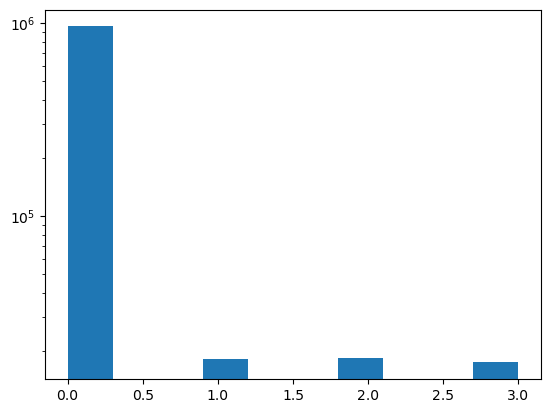

In [6]:
plt.hist(labels)
plt.yscale('log')
plt.show()

In [7]:
#normalize each column

maxes = np.max(np.abs(relevant_dat), axis = 0)
relevant_dat = relevant_dat/maxes[None,:]

In [8]:
import torchvision
from torch.utils.data import Dataset, DataLoader

rand_gen = np.random.RandomState(0)

total_inds = len(labels)

inds = np.arange(total_inds)
train_inds = rand_gen.choice(inds, replace = False, size = int(0.8*total_inds))
test_inds = np.setdiff1d(inds, train_inds)


batch_size = 5000

#no_sthmot_sense_data = np.delete(sense_data, 47, axis=1)

class train_PlumeDataset(Dataset):
    
    def __init__(self, data, labels, inds):
        
        self.x = torch.from_numpy(data[inds]).float()
        self.y = torch.from_numpy(labels[inds]).long()
        self.n_total = np.shape(data[inds])[0]
        
    def __getitem__(self,index):
        
        return self.x[index], self.y[index]
    
    def __len__(self):
        
        return self.n_total

    
print(np.shape(relevant_dat))

train_dataset = train_PlumeDataset(data = relevant_dat, labels = labels, inds = train_inds)
test_dataset = train_PlumeDataset(data = relevant_dat, labels = labels, inds = test_inds)


#creating training batches
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

check_iter = iter(train_loader)
check = next(check_iter)

features, labels = check

print(features.size())

/Users/vrj9/anaconda3/envs/plume-env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/vrj9/anaconda3/envs/plume-env/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <DDABACEB-F2EA-368C-80DD-40745DFB96F8> /Users/vrj9/anaconda3/envs/plume-env/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <06C5DED4-2345-38A0-A87B-C09CD199D899> /Users/vrj9/anaconda3/envs/plume-env/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


(1012669, 4)
torch.Size([5000, 4])


In [12]:
import torch.nn as nn
torch.manual_seed(98)

#first doing GLM

class NeuralNetGLM_Four(nn.Module):
    
    def __init__(self, input_size):
        super(NeuralNetGLM_Four, self).__init__()
        self.lin1 = nn.Linear(input_size, 1)
        self.lin2 = nn.Linear(input_size, 1)
        self.lin3 = nn.Linear(input_size, 1)
        self.lin4 = nn.Linear(input_size, 1)
        
        self.nl = nn.Sigmoid()
        
    def forward(self, x):
        
        f1 = self.lin1(x)
        f2 = self.lin2(x)
        f3 = self.lin3(x)
        f4 = self.lin4(x)
        
        #glm1 = self.nl(f1)
        #glm2 = self.nl(f2)
        #glm3 = self.nl(f3)
        #glm4 = self.nl(f4)
        
        out = torch.cat((f1, f2, f3, f4), dim = 1)
        
        return out


GLM = NeuralNetGLM_Four(input_size = 4)


#print(x)
#print(GLM.forward(x))
#print(GLM(x))


#for name, param in GLM.named_parameters():
    
#    print(name, param.data.size())


#for name, param in GLM.named_parameters():
    
#    if param.requires_grad and name == 'lin1.weight':
        
#        filt_1 = param.data.numpy()
#        print(filt_1)


In [13]:
learning_rate = 0.001
labels = all_dat[:,4]

#get weights

num_samples = np.shape(relevant_dat)[0]
prop_0 = np.mean(labels==0)
prop_1 = np.mean(labels==1)
prop_2 = np.mean(labels==2)
prop_3 = np.mean(labels==3)

prop_arr = np.array([prop_0, prop_1, prop_2, prop_3])
weights = 0.25/prop_arr
weights = torch.from_numpy(weights).float()

criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = torch.optim.Adam(GLM.parameters(), lr=learning_rate)

In [6]:
"""
print(features)
print(labels)

all_out = GLM(features)
#all_out = all_out.data.numpy()

def softmax(x):
    
    x = x.data.numpy()
    
    exp_array = np.exp(x)
    
    exp_sum = np.sum(exp_array, axis = 1)
    
    div_array = np.zeros(np.shape(x))
    div_array[:,0] = exp_sum
    div_array[:,1] = exp_sum
    div_array[:,2] = exp_sum
    div_array[:,3] = exp_sum
    
    return exp_array/div_array

all_out = softmax(all_out)

all_0 = all_out[:,0]
all_1 = all_out[:,1]
all_2 = all_out[:,2]
all_3 = all_out[:,3]

plt.hist(all_0, bins = 20)
plt.hist(all_1, bins = 20)
plt.hist(all_2, bins = 20)
plt.hist(all_3, bins = 20)

plt.show()

test_loss = criterion(GLM(features), labels)
print(test_loss.item())
"""

'\nprint(features)\nprint(labels)\n\nall_out = GLM(features)\n#all_out = all_out.data.numpy()\n\ndef softmax(x):\n    \n    x = x.data.numpy()\n    \n    exp_array = np.exp(x)\n    \n    exp_sum = np.sum(exp_array, axis = 1)\n    \n    div_array = np.zeros(np.shape(x))\n    div_array[:,0] = exp_sum\n    div_array[:,1] = exp_sum\n    div_array[:,2] = exp_sum\n    div_array[:,3] = exp_sum\n    \n    return exp_array/div_array\n\nall_out = softmax(all_out)\n\nall_0 = all_out[:,0]\nall_1 = all_out[:,1]\nall_2 = all_out[:,2]\nall_3 = all_out[:,3]\n\nplt.hist(all_0, bins = 20)\nplt.hist(all_1, bins = 20)\nplt.hist(all_2, bins = 20)\nplt.hist(all_3, bins = 20)\n\nplt.show()\n\ntest_loss = criterion(GLM(features), labels)\nprint(test_loss.item())\n'

In [14]:
num_epochs = 140
loss_array = np.zeros(int(num_epochs/2))

for epoch in range(num_epochs):
    
    for i, (features, labels) in enumerate(train_loader):
        
        #print(features.size())
        #print(labels.size())
        
        outputs = GLM(features)
        
        #print(outputs.size())
        
        #assert(False)
        
        loss = criterion(outputs, labels)
        
        if i == 0 and epoch %2 ==0:
        
            print(epoch)
            ind = int(epoch/2)
            loss_array[ind] = loss.item()
            print(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
epoch_labels = 2*np.arange(0,len(loss_array))      
plt.plot(epoch_labels, loss_array)
plt.show()


0
1.459227442741394
2
1.2096909284591675


KeyboardInterrupt: 

In [8]:
check_iter = iter(test_loader)
check = next(check_iter)

features, labels = check

print(features)
print(labels)

def softmax(x):
    
    x = x.data.numpy()
    
    exp_array = np.exp(x)
    
    exp_sum = np.sum(exp_array, axis = 1)
    
    div_array = np.zeros(np.shape(x))
    div_array[:,0] = exp_sum
    div_array[:,1] = exp_sum
    div_array[:,2] = exp_sum
    div_array[:,3] = exp_sum
    
    return exp_array/div_array

print(softmax(GLM(features)))

tensor([[ 1.4387e+01, -3.3515e-01,  0.0000e+00,  ...,  1.0000e+00,
          9.1205e-01,  4.1008e-01],
        [ 1.2460e+01, -1.2101e-01,  0.0000e+00,  ...,  1.0000e+00,
         -4.2923e-01, -9.0320e-01],
        [ 6.9716e+00,  8.3645e-02,  0.0000e+00,  ...,  1.0000e+00,
         -7.4369e-01,  6.6852e-01],
        ...,
        [ 3.8855e+00,  2.0867e-01, -2.2010e-02,  ...,  1.0000e+00,
         -9.4671e-01, -3.2209e-01],
        [ 1.6186e-01, -2.4698e-03,  1.0458e-04,  ...,  6.7593e-01,
          2.1908e-01, -9.7571e-01],
        [ 2.6743e+00, -2.2150e-01, -9.1298e-03,  ...,  1.0000e+00,
          9.2034e-01,  3.9112e-01]])
tensor([0, 0, 0,  ..., 0, 0, 0])
[[0.33038503 0.26368702 0.21783121 0.18809683]
 [0.3410153  0.27619305 0.20736774 0.17542399]
 [0.32888177 0.28379865 0.21257789 0.17474167]
 ...
 [0.10980752 0.2514674  0.32879742 0.30992758]
 [0.17910295 0.30589955 0.29314554 0.22185196]
 [0.22117419 0.32884491 0.28212369 0.16785722]]


In [20]:
test_feat, test_label = test_dataset[0]
#print(test_feat.size())

#test_feat.resize((1,9))

test_feat = test_feat.unsqueeze(0)

#check_iter = iter(test_loader)
#check = next(check_iter)

#features, labels = check

#print(features.size())

print(GLM(test_feat))

tensor([[-0.1223, -0.3478, -0.5389, -0.6856]], grad_fn=<CatBackward0>)


lin1.weight torch.Size([1, 5])
lin1.bias torch.Size([1])
lin2.weight torch.Size([1, 5])
lin2.bias torch.Size([1])
lin3.weight torch.Size([1, 5])
lin3.bias torch.Size([1])
lin4.weight torch.Size([1, 5])
lin4.bias torch.Size([1])
Parameter containing:
tensor([[ 1.4959,  0.0819, -0.7583, -4.8299, -0.4440]], requires_grad=True)
(1, 5)
(1, 5)
(1, 5)
(1, 5)


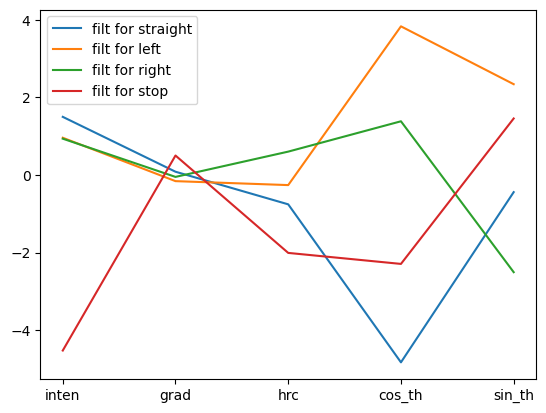

In [24]:
label_list = ['inten', 'grad', 'hrc', 'cos_th', 'sin_th']

fig = plt.figure()
ax = fig.add_subplot(111)

for name, param in GLM.named_parameters():
    
    print(name, param.data.size())


for name, param in GLM.named_parameters():
    
    if param.requires_grad and name == 'lin1.weight':
        
        #print('in 1')
        print(param)
        
        filt_1 = param.data.numpy()
        print(np.shape(filt_1))
        #print(filt_1.squeeze())
        ax.plot(filt_1.squeeze(), label = 'filt for straight')

    elif param.requires_grad and name == 'lin2.weight':
        
        #print('in 2')
        filt_2 = param.data.numpy()
        print(np.shape(filt_2))
        ax.plot(filt_2.squeeze(), label = 'filt for left')

        

    elif param.requires_grad and name == 'lin3.weight':
        
        #print('in 2')
        filt_3 = param.data.numpy()
        print(np.shape(filt_3))
        ax.plot(filt_3.squeeze(), label = 'filt for right')


    elif param.requires_grad and name == 'lin4.weight':
        
        #print('in 2')
        filt_4 = param.data.numpy()
        print(np.shape(filt_3))
        ax.plot(filt_4.squeeze(), label = 'filt for stop')
        
ax.set_xticks(np.arange(0,5))
ax.set_xticklabels(label_list)
plt.legend()
plt.show()


In [25]:
actions = all_dat[:,4]
print(np.sum(actions==1))
print(np.sum(actions==2))

14197
11742


In [26]:
#Evaluate and create confusion matrix

conf_matrix = np.zeros((4,4))

with torch.no_grad():
    
    for features, labels in test_loader:
        
        outputs = GLM(features)
        _, output_labels = torch.max(outputs.data, 1)
        
        for i in range(0,len(output_labels)):
            
            corr = labels[i]
            pred = output_labels[i]
            
            conf_matrix[corr, pred] = conf_matrix[corr, pred]+1
            
        loss = criterion(outputs, labels)
        print(loss.item())
            
conf_sum = np.sum(conf_matrix, axis = 1)


0.9781599640846252
1.0959116220474243
0.9738056659698486
0.9474474787712097
1.022739291191101
1.1055569648742676
0.9793649911880493
1.0265451669692993
0.9820525050163269
0.9634974598884583
0.9374409317970276
1.0359165668487549
0.981025218963623
0.9231297969818115
0.9493781328201294
0.9989124536514282
1.0055627822875977
1.0263996124267578
0.9976528286933899
1.0972586870193481
1.072648286819458
1.0890486240386963
0.9939610362052917
1.0158864259719849
1.0711787939071655
1.003405213356018
0.9425743222236633
1.012149691581726
0.9713308215141296
1.013708233833313
1.0143966674804688
1.0817866325378418
0.9617254137992859
0.9590542316436768
1.0140866041183472
1.0215831995010376
0.9900487065315247
0.9170401096343994
1.0418102741241455
1.0247125625610352
1.0571811199188232
1.0711791515350342
1.1091359853744507
0.9256458282470703
0.997488260269165
1.0158439874649048
1.0458595752716064
1.1038734912872314
0.9699580073356628
0.996429979801178
1.0523220300674438
1.040589451789856
1.0781174898147583
0.

In [27]:
conf_sum = np.array([conf_sum])
print(np.shape(conf_sum))

conf_sum_array = np.tile(conf_sum.transpose(), (1,4))

print(conf_sum_array)


print(np.shape(conf_sum_array))

print(conf_matrix/conf_sum_array)

(1, 4)
[[189461. 189461. 189461. 189461.]
 [  2806.   2806.   2806.   2806.]
 [  2281.   2281.   2281.   2281.]
 [151864. 151864. 151864. 151864.]]
(4, 4)
[[0.55503771 0.01342229 0.01491072 0.41662928]
 [0.17355666 0.55773343 0.08196721 0.18674269]
 [0.1354669  0.04427883 0.63963174 0.18062253]
 [0.15883949 0.00383896 0.16294184 0.67437971]]


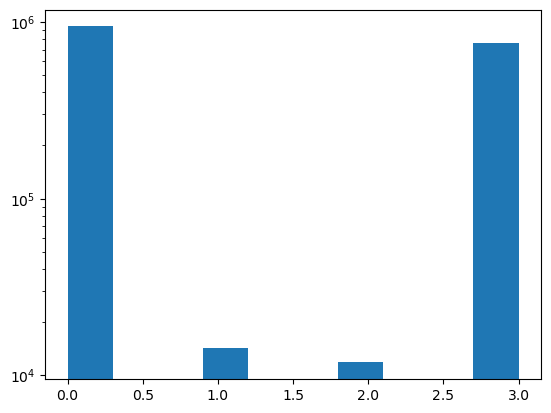

In [29]:
plt.hist(actions)
plt.yscale('log')
plt.show()